### Steps: 

>1. Get a pretrained model <br/>
    1. Define two classes to construct the CycleGAN architecture <br/>
    2. Load pretrained weights to get the pretrained model <br/>
2. Compose the preprocess for model input <br/>
3. Prepare a input <br/>
4. Preprocess the input to fullfil the model's input format <br/>
5. Set model to evaluation mode <br/>
6. Send the preprocessed input to the model <br/>
7. Print the model output

### Step: 

>1. **Get a pretrained model** <br/>
    1. **Define two classes to contrust the CycleGAN architecture**<br/>
    2. <font color='gray'>Load pretrained weights to get the pretrained model</font>

In [1]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

### Step: 

>1. **Get a pretrained model** <br/>
    1. <font color='gray'>Define two classes to construct the CycleGAN architecture</font> </br>
    2. **Load pretrained weights to get the pretrained model**

In [2]:

model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)

netG = ResNetGenerator()
netG.load_state_dict(model_data)


<All keys matched successfully>

### Step: 

>**2. Compose the preprocess for model input** <br/>

In [3]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

### Step: 

>**3. Prepare a input** <br/>

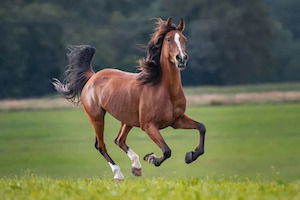

In [4]:
img = Image.open("./dlwpt-code/data/p1ch2/horse.jpg")
# img = Image.open("horse.jpeg")
img

### Step: 

>**4. Preprocess the input to fullfil the model's input format** <br/>

In [5]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_t)


### Step: 
>**5. Set model to evaluation mode** <br/>
**6. Send the preprocessed input to the model** <br/>
**7. Print the model output**

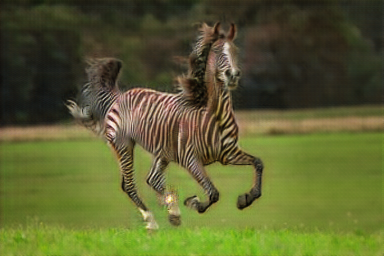

In [6]:
netG.eval()

out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
# out_img.save('../data/p1ch2/zebra.jpg')
out_img
